# Part 1: Prepare data

In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, random, datetime

In [2]:
# Set options

%matplotlib inline
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
pd.options.display.max_columns=100
pd.options.display.max_rows=100

np.random.seed(42)

In [3]:
# ignore deprecation warnings in sklearn

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read in the data

df_user = pd.read_csv("takehome_users.csv", encoding = "ISO-8859-1")
df_engage = pd.read_csv("takehome_user_engagement.csv", encoding = "ISO-8859-1")

In [5]:
# Glimpse the user dataset

print(df_user.head())

   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   

In [6]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


<font color=GREEN> We see that a two columns have missing values (last_session_creation_time and invited_by_user_id). For last_session_creation_time, the value can probably be found on the engagement table. For invited_by_user_id, we will assume that the missing values are non-referals and will assign it a value of 0. Apart from that, we see that a few columns have the wrong python datatype that needs to be fixed (invited_by_user_id is float instead of integer, creation_time should be datetime object).</font>

In [7]:
# Glimpse the user engagement dataset

print(df_engage.head())

            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1


In [8]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


<font color=GREEN> We can also set the time_stamp to datetime and set it to index for easy manipulations.</font>

## Preprocessing

In [9]:
# Impute the referal columns and set to integer

df_user['invited_by_user_id'] = df_user.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else x).astype("int")

In [10]:
# Let's take a look at the last_session_creation_time to see if the value is really missing

# First, convert the unix timestamp object to pandas datetime
df_user['last_session_creation_time'] = pd.to_datetime(df_user['last_session_creation_time'], unit = 's')

# Next, convert the timestamp object in df_engage to pandas datetime
df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'])

In [11]:
# Derive last_log_in of each user from the df_engage
last_log_in = df_engage.groupby(['user_id'])['time_stamp'].max()

In [12]:
len(last_log_in)

8823

<font color=GREEN> It seems these values are really missing. We will have to assume these users sign up but never logged on. We'll have to convert this variable into a variable that measures the days since last log in and we can also extract a boolean variable based on whether they logged-in at all</font>

In [13]:
# Extract logged_in
df_user['logged_in'] = df_user['last_session_creation_time'].apply(lambda x: True if type(x) is pd.Timestamp else False)

In [14]:
# Extract days_since_log_in. If the user has not logged in for 2 years, set to 730 days
today = max(df_engage["time_stamp"])
df_user["days_since_log"] = df_user["last_session_creation_time"].apply(lambda x: (today - x).days if type(x) is pd.Timestamp else 730)

# Extract days_since_create
df_user['days_since_create'] = pd.to_datetime(df_user['creation_time']).apply(lambda x: (today - x).days)

# Drop the two date columns
df_user = df_user.drop(['last_session_creation_time', 'creation_time'], axis = 1)

In [15]:
# Type convert the rest of the variables in df_user
df_user['opted_in_to_mailing_list'] = df_user['opted_in_to_mailing_list'].astype('bool')
df_user['enabled_for_marketing_drip'] = df_user['opted_in_to_mailing_list'].astype('bool')
df_user['creation_source'] = df_user['creation_source'].astype('category')
df_user['invited_by_user_id'] = df_user['invited_by_user_id'].astype('category')

In [16]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
opted_in_to_mailing_list      12000 non-null bool
enabled_for_marketing_drip    12000 non-null bool
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null category
logged_in                     12000 non-null bool
days_since_log                12000 non-null int64
days_since_create             12000 non-null int64
dtypes: bool(3), category(2), int64(4), object(2)
memory usage: 733.1+ KB


# Part 2: Label extraction

In [17]:
# Sort the df_engage by user and time_stamp for easier processing
df_engage = df_engage.sort_values(["user_id", "time_stamp"])

# Since we only need dates, extract only the date to reduce computational cost
df_engage['date'] = df_engage.time_stamp.apply(lambda x: x.date())

# Check dataframe
df_engage.head()

,time_stamp,user_id,visited,date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [18]:
%%time

# Initialize an empty dictionary to store our label
adopted_user_dict = {}

# Loop through every user_id to determine if that user has adopted the product based on the definition
for user_id in set(df_engage.user_id):
    
    # Derive all dates of the instances of log in of that particular user
    log_ins = df_engage[df_engage['user_id'] == user_id].date
    
    # For each date, determine the day difference between that date and 2 log-in further. 
    two_logins_diff = [j - i for i, j in zip(log_ins[: -1], log_ins[2 :])]
    
    if len(two_logins_diff) == 0:
        
        # if there's no difference, the user never made more than 2 log-ins, so that user has not adopted
        adopted_user_dict[user_id] = False
    else:
        # if the user made more than 2 log-ins, find the minimum of the spaced log-in. If it's less than or equal to 7, the user is adopted.
        adopted_user_dict[user_id] = (min(two_logins_diff).days <= 7)

# map the results onto the label column in the df_user dataframe, filling any missing user (users who never logged-in) as False         
df_user['label'] = df_user.object_id.map(adopted_user_dict).fillna(False)

Wall time: 17.5 s


In [19]:
df_user.head()

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,logged_in,days_since_log,days_since_create,label
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,True,True,11,10803,True,45,45,False
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,False,False,1,316,True,67,203,True
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,False,False,94,1525,True,443,443,False
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,False,False,1,5151,True,380,381,False
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,False,False,193,5240,True,500,505,False


# Part 3: Adoption factor identification

In [20]:
df = df_user.copy().drop(['object_id', 'name', 'email', 'invited_by_user_id'], axis = 1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
creation_source               12000 non-null category
opted_in_to_mailing_list      12000 non-null bool
enabled_for_marketing_drip    12000 non-null bool
org_id                        12000 non-null int64
logged_in                     12000 non-null bool
days_since_log                12000 non-null int64
days_since_create             12000 non-null int64
label                         12000 non-null bool
dtypes: bool(4), category(1), int64(3)
memory usage: 340.1 KB


## Random forest feature importance

We build a quick random forest model to explore feature importance. I suspect a random forest model will provide a good approach since there's likely only a few factors for which a user decide to adopt the product.

In [22]:
print("The fraction of users who are adopted is %.2f %%" %(df.label.value_counts()[1]/len(df.label)*100))

The fraction of users who are adopted is 13.80 %


In [23]:
# Import random forest to visualize feature importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [24]:
# Define X and y, then run feature importance

X = pd.get_dummies(df, columns=["creation_source"]).drop("label", axis = 1)
y = df.label

In [25]:
print("We have {} training features".format(len(X.columns)))

We have 11 training features


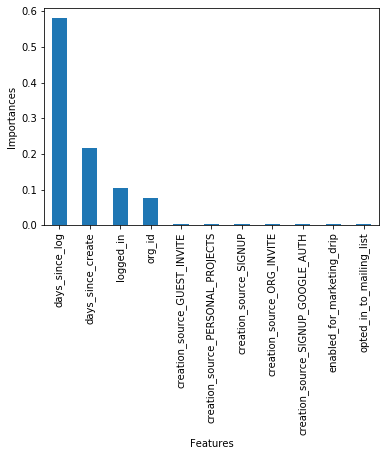

In [26]:
scaler = StandardScaler()

forest = RandomForestClassifier(n_estimators=10,
                                max_features = 'sqrt',
                               class_weight = 'balanced')

forest.fit(scaler.fit_transform(X), y)

importances = forest.feature_importances_

importances_df = pd.DataFrame.from_dict(dict(zip(X.columns, importances)), orient='index', columns = ["importances"])

importances_df.sort_values("importances", ascending = False).plot(kind = 'bar', legend = None)
plt.xlabel('Features')
plt.ylabel('Importances')
plt.show()

<font color=GREEN> <b>Factor identification: </b>Feature importances (which is calculated by the reduction in gini impurity once the feature is introduced) show that days_since_log and days_since_create has a strong impact on split decision of the trees. Features like org_id and logged_in has moderate impact. Let's see how accurate our model is by tuning our hyper-parameter with GridSearch</font>

In [27]:
# Import sklearn functions

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [28]:
# Define X and y

X = pd.get_dummies(df, columns=["creation_source"]).drop("label", axis = 1)
  
# Encode labels in column 'species'. 
y = LabelEncoder().fit_transform(df['label']) 

indices = df.index

# Split train and test set

Xtrain, Xtest, ytrain, ytest, itrain, itest = train_test_split(X, y, indices, train_size = 0.8, random_state = 42)

## Random Forest

In [29]:
# Create pipeline which includes Scaling and Random Forest, 
# Create a classifier using Cross-validated GridSearch for the best parameters

cv = 10
metric = "accuracy"
steps = [('scaler', StandardScaler()), 
         ('model', RandomForestClassifier(class_weight = 'balanced'))]
pipeline = Pipeline(steps)
parameters = {'model__n_estimators':[10 , 20, 30, 40, 50],
             'model__max_features': ['auto', 'sqrt', 'log2']}

clf = GridSearchCV(pipeline, 
                   parameters, 
                   n_jobs = -1,
                   cv = cv, 
                   scoring=metric,
                   verbose = 10)
clf.fit(Xtrain, ytrain)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   28.4s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight='balanced',
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
         

In [30]:
# Evaluate
acc_score = accuracy_score(ytest, clf.predict(Xtest))
f1macro_score = f1_score(ytest, clf.predict(Xtest), average = "macro")
cm = confusion_matrix(ytest, clf.predict(Xtest))

print("The best parameters used was: ",clf.best_params_)
print("The Accuracy score is: ", round(acc_score, 3))
print("The F1 score is: ", round(f1macro_score, 3))
print("Confusion matrix: \n", cm) 

The best parameters used was:  {'model__max_features': 'sqrt', 'model__n_estimators': 50}
The Accuracy score is:  0.962
The F1 score is:  0.916
Confusion matrix: 
 [[2046   17]
 [  73  264]]


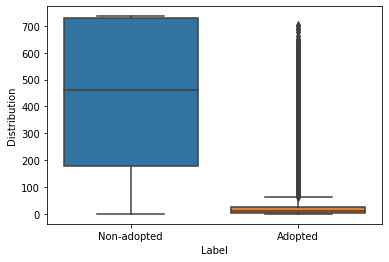

In [31]:
# How discriminative is days_since_log

sns.boxplot(data = [df[df.label == 0].days_since_log, df[df.label == 1].days_since_log])
plt.xticks((0,1),("Non-adopted", "Adopted"))
plt.xlabel('Label')
plt.ylabel('Distribution')
plt.show()

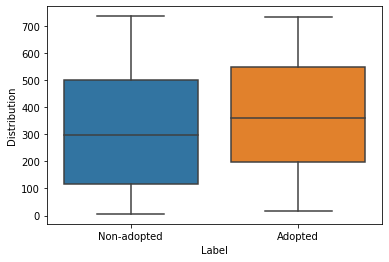

In [32]:
# How discriminative is days_since_create

sns.boxplot(data = [df[df.label == 0].days_since_create, df[df.label == 1].days_since_create])
plt.xticks((0,1),("Non-adopted", "Adopted"))
plt.xlabel('Label')
plt.ylabel('Distribution')
plt.show()

<font color=GREEN> <b>Results</b>: The model was able to achieve an impressive 96.2% accuracy score and 0.915 f1 score, which tells us that the model was able to distinguish the class very accurately. This proves that the features were found were indeed very important. For example, the box plots of the two most important features show that if a user has logged in recently, he/she is extremely likely to be adopted.</font>

<font color=GREEN> <b>Further research:</b> Although our model was able to achieve a very accurate score, to reflect the reality of the business, I think the criteria for a user to be label to be "adopted" should be more rigorously researched. For instance, if a user logged in 3 times within a week a long time ago, but hasn't logged in at all since then, the user would still be labeled adopted despite his/her inactivity.</font>